In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
pplot.set_plot_params()
scatter_kws={'s':2}

In [4]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
traceid='traces001'
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


## Load RF fits (aggr)

In [5]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rfdf = rfutils.aggregate_fits(cells0, meta, combine='single', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
count_rfs = aggr.count_n_cells(rfdf)
print(count_rfs.groupby('visual_area').sum())

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
             n_cells
visual_area         
Li               419
Lm               351
V1               814


# Load gradient results

In [6]:
# dk = '20191111_JC117_fov1
# dk ='20190617_JC097_fov1'
# dk = '20191006_JC110_fov1'
# dk = '20190522_JC084_fov1'

In [31]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [6]:
#dk='20190617_JC099_fov1'
# dk='20190602_JC091_fov1'
# va='Li'

# dk='20191111_JC117_fov2'
# va='Lm'

# dk='20191006_JC110_fov1'
# va='V1'

dk='20190522_JC084_fov1'
va='V1'

experiment = 'rfs10' if va=='Li' else 'rfs'
# dk='20190430_JC078_fov1'
# va='Lm'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=False)

... calculating global gradients (20190522_JC084_fov1, V1)
Target: 25 (fwhm=12, k=(1, 1))
start -0.8029543069761487 2.6209032281680855


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1142: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


smoothed -0.03280914184405068 1.6730408272597268


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:267: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:268: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.2988701484602041 1.525795710086726
fillnan 0.2988701484602041 1.525795710086726


#### Check gradients

<IPython.core.display.Javascript object>


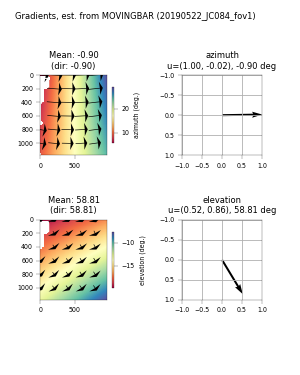

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20190522_JC084_fov1)')

In [7]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk, fontsize=8)

In [8]:
mag_thr=0.02
retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=mag_thr,
            delay_map_thr=1)
curr_np = retinodf_np[retinodf_np.visual_area==va].copy()          

<IPython.core.display.Javascript object>


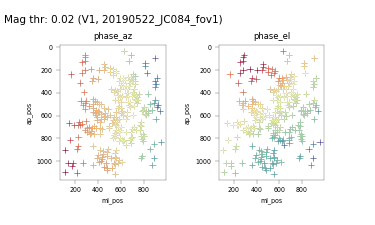

In [9]:
fig, axn = pl.subplots(1,2, figsize=(5,3))
ax=axn[0]
for ax, hue_label in zip(axn.flat, ['phase_az', 'phase_el']):
    sns.scatterplot(x='ml_pos', y='ap_pos', 
                    color=[0.5]*3, data=retinodf_np, ax=ax, marker='+')
    sns.scatterplot(x='ml_pos', y='ap_pos', hue=hue_label, 
                    palette='Spectral', data=curr_np, ax=ax, marker='+')
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(hue_label)
    ax.legend_.remove()
fig.text(0.01, 0.9, 'Mag thr: %.2f (%s, %s)' % (mag_thr, va, dk))
pl.subplots_adjust(top=0.8, bottom=0.2)

In [10]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

(1144044, 20)


<IPython.core.display.Javascript object>


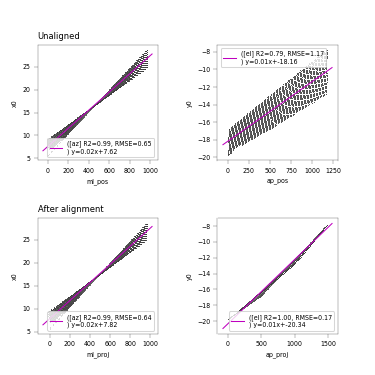

In [11]:
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_pixels(dk, va, retinorun,
                                                    GVECTORS, create_new=False)
print(aligned_np.shape)
fig = sct.plot_pre_and_post_pixel_alignment(aligned_np, REGR_NP, regr_np_meas)


In [13]:
REGR_NP

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.986521,0.637739,0.0,0.993238,0.019804,7.816520,az
1,0.995476,0.173019,0.0,0.997735,0.008107,-20.337675,el


#### Load Neuropil data points

(260, 23)
MEASURED:
|    |       R2 |    RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.910532 | 1.05994 | 3.02576e-137 |    0.954218 |    0.0173203  |     8.26782 | az     |
|  1 | 0.666672 | 1.50771 | 1.71159e-63  |    0.8165   |    0.00835413 |   -19.1376  | el     |
ALIGNED:
|    |       R2 |     RMSE |    pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|-------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.913413 | 1.04273  | 4.43109e-139 |    0.955727 |     0.0172853 |     8.44895 | az     |
|  1 | 0.91246  | 0.772656 | 1.82067e-138 |    0.955228 |     0.0111252 |   -23.0019  | el     |


<IPython.core.display.Javascript object>


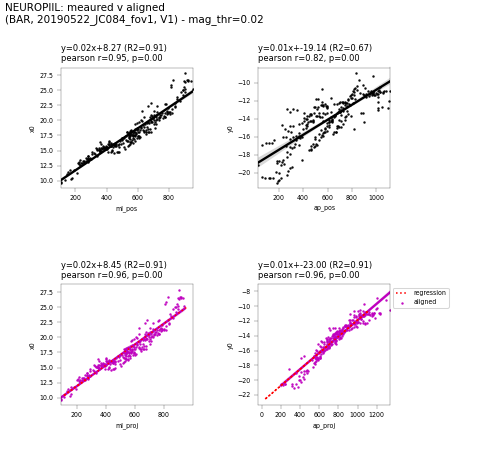

In [14]:
%matplotlib notebook
mag_thr=0.02
delay_map_thr=0.5
ds_factor=1

aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_neuropil(dk, va, retinorun,
                                                    GVECTORS, mag_thr=mag_thr, 
                                                    delay_map_thr=delay_map_thr, 
                                                    ds_factor=ds_factor,
                                                    abs_value=False)
print(aligned_np.shape)
# Save
# sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

%matplotlib notebook
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, \
         'NEUROPIIL: meaured v aligned\n(BAR, %s, %s) - mag_thr=%.2f' % (dk, va, mag_thr))

pl.subplots_adjust(bottom=0.1, right=0.8)

In [15]:
aligned_soma.head()

NameError: name 'aligned_soma' is not defined

In [16]:
importlib.reload(sct)
#### Align soma coords to gradient
aligned_soma = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
                                   response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction,
                                   abs_value=False)
aligned_soma[aligned_soma.reliable]

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
0,24.876325,-10.753185,24.021635,16.906345,0.057323,0.001951,-0.025894,0.767913,10.221972,7.194189,...,1100.992518,24.708017,-9.589041,961.513511,704.905163,0.168307,-1.164144,9.737016,104.640657,False
1,27.627541,-9.198699,36.760755,19.990691,6.066365,-0.002898,0.027681,0.561637,15.642875,8.506677,...,1240.719635,23.617751,-8.624194,1121.736072,771.237502,4.009790,-0.574505,231.976986,51.640150,False
2,17.433088,-11.532854,27.889204,21.404847,6.220338,-0.004471,0.048655,0.585081,11.867746,9.108446,...,1030.910927,21.609465,-9.249470,533.621755,882.057429,-4.176376,-2.283384,241.614462,205.245115,False
3,23.867409,-11.367222,24.879592,20.229131,0.103731,-0.007522,0.105426,0.852636,10.587060,8.608141,...,1045.798988,22.057889,-11.003917,902.685634,676.001897,1.809520,-0.363305,104.685527,32.656175,True
4,24.144343,-11.700484,17.091076,23.108700,1.607293,-0.001759,0.033900,0.526608,7.272798,9.833490,...,1015.843263,21.694094,-11.058787,918.015822,631.701027,2.450249,-0.641697,141.753445,57.679773,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,11.539420,-10.433394,21.133042,14.711042,0.021120,-0.005110,0.083963,0.609029,8.992784,6.260018,...,1129.737406,15.217694,-11.070511,197.606814,1201.036915,-3.678274,0.637117,212.797938,57.268150,True
130,15.654976,-13.197787,19.910563,14.220851,0.296442,-0.006404,0.132595,0.799179,8.472580,6.051426,...,881.256155,16.508747,-14.425841,428.994395,770.457828,-0.853771,1.228054,49.392941,110.385274,True
131,17.190074,-14.179973,24.517514,22.685233,0.988748,0.004882,-0.047279,0.613909,10.432985,9.653291,...,792.971025,17.522486,-13.866475,515.381444,614.945486,-0.332412,-0.313498,19.230908,28.179178,True
132,17.214556,-11.933111,23.500077,21.485520,6.010178,-0.005097,0.066128,0.683492,10.000033,9.142775,...,994.933236,17.708682,-13.405897,520.444261,847.977536,-0.494126,1.472786,28.586512,132.383355,True


In [23]:
projdf = sct.stack_axes(aligned_soma)

In [25]:
projdf.head()

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,aniso_index,ratio_xy,...,std,vectorproj,ctx_pos,ctx_proj,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,axis
0,rfs,V1,20190522_JC084_fov1,0,0.767913,0.057323,0.001951,-0.025894,-0.153929,1.420865,...,10.221972,10.205182,953.762818,940.630297,950.367313,24.708017,961.513511,0.168307,9.737016,az
1,rfs,V1,20190522_JC084_fov1,1,0.561637,6.066365,-0.002898,0.027681,-0.168361,1.838894,...,15.642875,15.276617,892.843836,877.555483,1109.532468,23.617751,1121.736072,4.009790,231.976986,az
2,rfs,V1,20190522_JC084_fov1,5,0.585081,6.220338,-0.004471,0.048655,-0.115021,1.302939,...,11.867746,11.844317,776.717025,761.370776,519.756314,21.609465,533.621755,-4.176376,241.614462,az
3,rfs,V1,20190522_JC084_fov1,9,0.852636,0.103731,-0.007522,0.105426,-0.081745,1.229889,...,10.587060,10.530152,799.561644,787.313312,891.998839,22.057889,902.685634,1.809520,104.685527,az
4,rfs,V1,20190522_JC084_fov1,10,0.526608,1.607293,-0.001759,0.033900,-0.138769,0.739595,...,7.272798,0.358813,778.620744,766.266810,908.020255,21.694094,918.015822,2.450249,141.753445,az


In [37]:
# test loading
print(dk,va, experiment)
df0 = sct.load_scatter_results(dk, va, experiment, verbose=False)


20190522_JC084_fov1 V1 rfs


Do model? False
... loading gradient vectors (20190522_JC084_fov1, V1)


<IPython.core.display.Javascript object>


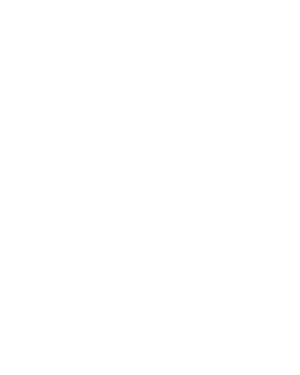

<IPython.core.display.Javascript object>


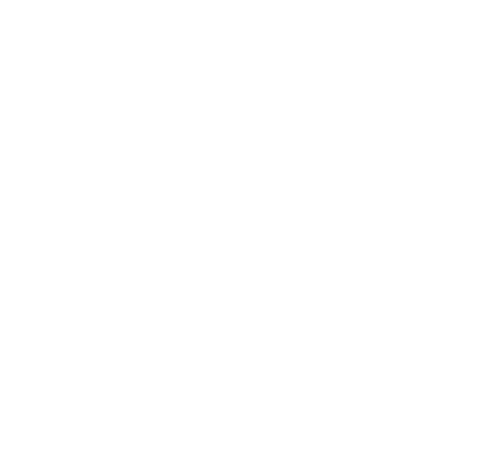

<IPython.core.display.Javascript object>


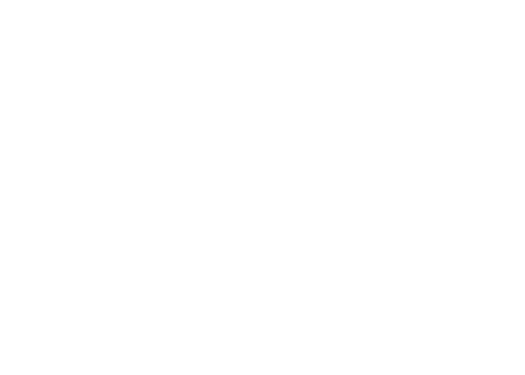

<IPython.core.display.Javascript object>


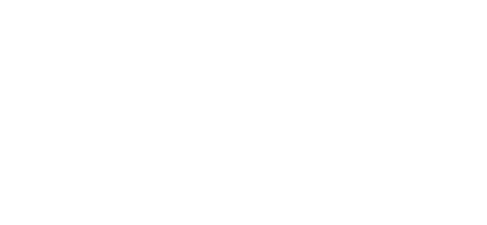

In [41]:
df1 = sct.do_scatter_analysis(dk, va, experiment=experiment, create_new=True)

In [42]:
df0['deg_scatter_abs'] = df0['deg_scatter'].abs()
df1['deg_scatter_abs'] = df1['deg_scatter'].abs()

<IPython.core.display.Javascript object>


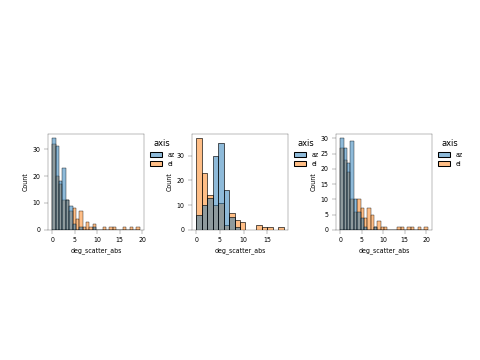

In [44]:
df = projdf[projdf.reliable].copy()
df_load = df0[df0.reliable].copy()
df_new = df1[df1.reliable].copy()

df['deg_scatter_abs'] = df['deg_scatter'].abs()
fig, axn = pl.subplots(1, 3)
ax=axn[0]
sns.histplot(x='deg_scatter_abs', data=df, ax=ax, 
             hue='axis')
pplot.sns_histplot_legend(ax)

ax=axn[1]
sns.histplot(x='deg_scatter_abs', data=df_load, ax=ax, 
             hue='axis')
pplot.sns_histplot_legend(ax)

ax=axn[2]
sns.histplot(x='deg_scatter_abs', data=df_new, ax=ax, 
             hue='axis')
pplot.sns_histplot_legend(ax)

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5)

# ax.legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False)

#### Load soma

    130 of 134 reliable
MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.810703 | 2.09535 | 1.50371e-49 |    0.90039  |     0.0233464 |     4.54192 | az     |
|  1 | 0.638294 | 3.36684 | 6.13758e-31 |    0.798933 |     0.019885  |   -28.0003  | el     |
ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.816148 | 2.06499 | 2.183e-50   |    0.903409 |     0.0233878 |     4.72534 | az     |
|  1 | 0.624711 | 3.42948 | 7.06664e-30 |    0.790387 |     0.0212645 |   -33.2397  | el     |


<IPython.core.display.Javascript object>


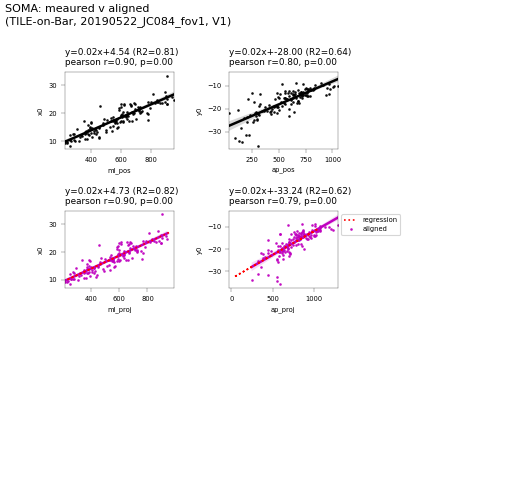

In [69]:
#### Align soma coords to gradient
# aligned_soma = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment=experiment,
#                                    response_type=response_type, 
#                                    do_spherical_correction=do_spherical_correction,
#                                    abs_value=False)
#### (alrady done above, but get regr. values)
regr_soma_meas = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
# plot
fig = sct.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'SOMA: meaured v aligned\n(TILE-on-Bar, %s, %s)' % (dk, va))
pl.subplots_adjust(bottom=0.4, right=0.65)
# figname = 'compared_measured_vs_aligned_CTX_to_RETINO'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [59]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

<IPython.core.display.Javascript object>


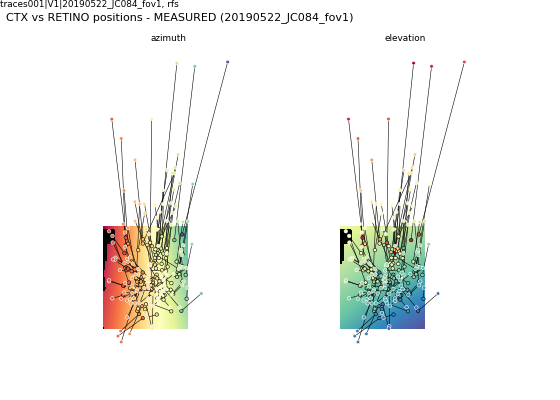

In [78]:
fig = sct.do_visualization(dk, va, aligned_soma[aligned_soma.reliable], 
                           AZMAP_NP, ELMAP_NP,
                        experiment=experiment, traceid=traceid,
                           markersize=10, lw=0.5, alpha=1, cmap='Spectral',
                        plot_true=True, plot_predicted=True, plot_lines=True,
                           return_fig=True)

In [79]:
aligned_soma.head()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
0,24.876325,-10.753185,24.021635,16.906345,0.057323,0.001951,-0.025894,0.767913,10.221972,7.194189,...,1100.992518,24.708017,-9.589041,961.513511,704.905163,0.168307,-1.164144,9.737016,104.640657,False
1,27.627541,-9.198699,36.760755,19.990691,6.066365,-0.002898,0.027681,0.561637,15.642875,8.506677,...,1240.719635,23.617751,-8.624194,1121.736072,771.237502,4.009790,-0.574505,231.976986,51.640150,False
2,17.433088,-11.532854,27.889204,21.404847,6.220338,-0.004471,0.048655,0.585081,11.867746,9.108446,...,1030.910927,21.609465,-9.249470,533.621755,882.057429,-4.176376,-2.283384,241.614462,205.245115,False
3,23.867409,-11.367222,24.879592,20.229131,0.103731,-0.007522,0.105426,0.852636,10.587060,8.608141,...,1045.798988,22.057889,-11.003917,902.685634,676.001897,1.809520,-0.363305,104.685527,32.656175,True
4,24.144343,-11.700484,17.091076,23.108700,1.607293,-0.001759,0.033900,0.526608,7.272798,9.833490,...,1015.843263,21.694094,-11.058787,918.015822,631.701027,2.450249,-0.641697,141.753445,57.679773,True


In [82]:
va, dk

('V1', '20190522_JC084_fov1')

In [81]:
aligned_soma[(aligned_soma.reliable) 
           & (aligned_soma['dist_scatter_ap']>800)]\
[['cell', 'x0', 'y0', 'r2', 'predicted_ap_pos', 'predicted_ml_pos']]

,cell,x0,y0,r2,predicted_ap_pos,predicted_ml_pos
19,36,33.557060,-32.709760,0.802387,-1881.867948,1423.302592
20,38,27.038247,-34.401938,0.853112,-1831.782401,1046.909468
31,64,23.475633,-25.883892,0.508176,-821.479880,856.586081
36,70,23.496582,-35.936489,0.879235,-1868.607840,841.413423
40,76,18.350554,-31.507353,0.778443,-1228.979870,553.674040
43,79,14.910692,-28.156832,0.767435,-760.838443,361.969650
45,85,10.431029,-34.127883,0.592390,-1226.918526,95.484632
103,187,12.252096,-31.383960,0.716589,-1004.494654,204.331437


In [96]:
check_rois=[35, 81, 87, 255]
aligned_soma[aligned_soma.cell.isin(check_rois)]\
[['cell', 'x0', 'y0', 'r2', 'predicted_ap_pos', 'predicted_ml_pos']]

,cell,x0,y0,r2,predicted_ap_pos,predicted_ml_pos
18,35,26.263475,-21.700369,0.734629,-482.755347,1023.189993
44,81,14.753551,-23.590260,0.780055,-280.038633,360.400750
46,87,19.053026,-20.407244,0.646026,-97.919173,612.016942
132,255,17.214556,-11.933111,0.683492,847.977536,520.444261


In [42]:
print(GVECTORS)

df_soma = sct.load_soma_data(dk, experiment=experiment,
                         response_type=response_type,
                         do_spherical_correction=do_spherical_correction)
curr_somas = df_soma[df_soma.visual_area==va].copy()    

{'az': array([0.97361407, 0.22820087]), 'el': array([0.32565112, 0.94549   ])}


<IPython.core.display.Javascript object>


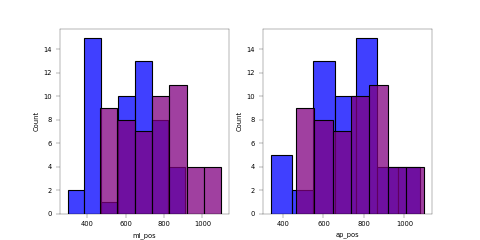

<AxesSubplot:xlabel='ap_pos', ylabel='Count'>

In [43]:

aligned_, M = sct.project_onto_gradient(curr_somas, GVECTORS)
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
sns.histplot(x='ml_pos', data=curr_somas, ax=ax, color='b', label='pos')
sns.histplot(x='ml_proj', data=aligned_, ax=ax, color='purple', label='proj')

ax=axn[1]
sns.histplot(x='ap_pos', data=curr_somas, ax=ax, color='b')
sns.histplot(x='ml_proj', data=aligned_, ax=ax, color='purple', label='proj')


# Plot

In [105]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'retinotopy', 'scatter/%s' % rf_str)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/retinotopy/scatter/


## predicted_vs_measured_fov_overlay

In [106]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

In [107]:
inbounds_soma = aligned_soma[(aligned_soma.inbounds)
                            & (aligned_soma.reliable)].copy()

In [108]:
# Make sure we are in bounds of FOV
ap_lim, ml_lim = AZMAP_NP.shape
print(ap_lim, ml_lim)
incl_plotdf = inbounds_soma[(inbounds_soma['predicted_ml_pos']>=0) 
                            & (inbounds_soma['predicted_ml_pos']<=ml_lim) 
                            & (inbounds_soma['predicted_ap_pos']>=0)
                            & (inbounds_soma['predicted_ap_pos']<=ap_lim)].copy()
excl_ixs = [i for i in inbounds_soma.index.tolist() if i not in incl_plotdf.index]
# plotdf = inbounds_soma.copy() 
plotdf = incl_plotdf.iloc[0::].copy()

1177 972


In [109]:
vmin = min([np.nanmin(AZMAP_NP), plotdf['x0'].min()])
vmax = max([np.nanmax(AZMAP_NP), plotdf['x0'].max()])
print("AZ: min/max = %.2f, %.2f" % (vmin, vmax))
az_min=np.floor(vmin)
az_max=np.ceil(vmax)

vmin = min([np.nanmin(ELMAP_NP), plotdf['y0'].min()])
vmax = max([np.nanmax(ELMAP_NP), plotdf['y0'].max()])
print("EL: min/max = %.2f, %.2f" % (vmin, vmax))
el_min=np.floor(vmin)
el_max=np.ceil(vmax)

AZ: min/max = 5.69, 29.03
EL: min/max = -22.08, -7.59


<IPython.core.display.Javascript object>


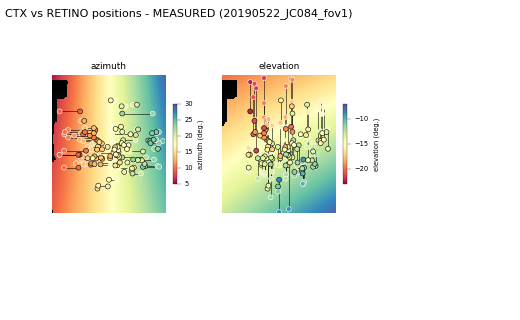

In [110]:
single_axis=True
roi_interval = 1
plot_true=True
plot_predicted=True
plot_lines=True

cmap='Spectral'
color_true='k'
color_predicted='w'

markersize=20
lw=0.5
alpha=1

fig, axn = pl.subplots(1, 2, figsize=(6.5,4))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = az_min if cond=='azimuth' else el_min #min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = az_max if cond=='azimuth' else el_max #max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    sm = pl.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.figure.colorbar(sm, ax=ax, shrink=0.5, label='%s (deg.)' % cond)
    
    if single_axis:
        pred_x = 'predicted_ml_pos' if cond=='azimuth' else 'ml_pos'
        pred_y = 'predicted_ap_pos' if cond=='elevation' else 'ap_pos'
    else:
        pred_x = 'predicted_ml_pos'
        pred_y = 'predicted_ap_pos'
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x=pred_x, y=pred_y, 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_predicted, zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[[pred_x, pred_y]].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_true, zorder=1000) 
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

figname = 'scatter_example_%s' % dk
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

# Calculate scatter

In [147]:
# Load scatter analysis for current FOV
scatter0 = sct.load_scatter_results(dk, va, experiment, verbose=False)
# Get cells with reliable fits
fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                do_spherical_correction=do_spherical_correction)
eval_results, eval_params = rfutils.load_eval_results(dk, experiment=experiment, 
                                traceid=traceid, fit_desc=fit_desc)   
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                pass_criterion='position')
# Assign reliable index
found_rois = scatter0['cell'].unique()
scatter0['reliable'] = False
scatter0.loc[scatter0['cell'].isin(reliable_), 'reliable'] = True

In [148]:
# Identify "true deviants"
devs_ = sct.get_deviants_in_fov(dk, va, experiment=experiment, redo_fov=False,
                     traceid=traceid, response_type=response_type, 
                     do_spherical_correction=do_spherical_correction)               
devs_ = devs_.rename(columns={'deviants': 'cell'})
devs_['deviant'] = True
# merge
scatter_ = scatter0.merge(devs_, on=['cell', 'axis'], how='outer')
scatter_ = scatter_.fillna(value=False).sort_values(by=['cell', 'axis'])\
                   .reset_index(drop=True)

In [149]:
# Only get reliable
rois_ = np.intersect1d(reliable_, aligned_soma[aligned_soma.inbounds]['cell'].unique())
boot_ = eval_results['bootdf'][eval_results['bootdf']['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
fitrfs_ = aligned_soma[aligned_soma['cell'].isin(rois_)].copy()
fitrfs_.index = fitrfs_['cell'].values

<IPython.core.display.Javascript object>


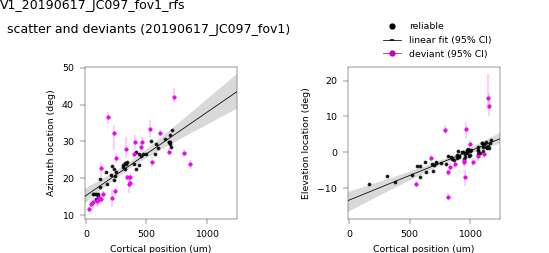

In [150]:
%matplotlib notebook
ci = 0.95
fill_marker=True
deviant_color='magenta'

fig, axn = pl.subplots(1, 2, figsize=(6.5,3), dpi=150, sharex=True)
for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
#     if cond=='az':
#         ax.set_ylim([0, 60])
#     else:
#         #pass
#         ax.set_ylim([-60, -0])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1250])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, fitrfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws={'s': 2, 'marker': 'o'}, line_kws={'lw': 0.5}, 
                          deviant_color=deviant_color, legend=cond=='el')
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cortical position (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    ax.set_box_aspect(1)

leg_h = pplot.custom_legend_markers(colors=['k', 'k', 'm'],
                    labels=['reliable', 'linear fit (95% CI)', 'deviant (95% CI)'],
                    markers=['o', '_', 'o'], lws=[0, 0.5, 0.5])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right',
          frameon=False, fontsize=6, markerscale=0.5)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.35, top=0.8, wspace=0.5)

fig.text(0.01, 0.9, 'scatter and deviants (%s)' % dk, fontsize=8)
pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))

# figname = 'deviants_example_%s' % dk
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


<IPython.core.display.Javascript object>


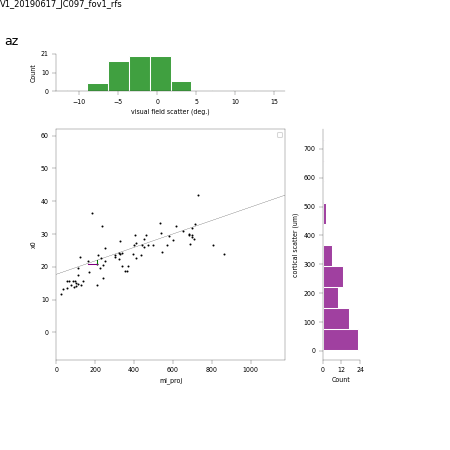

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


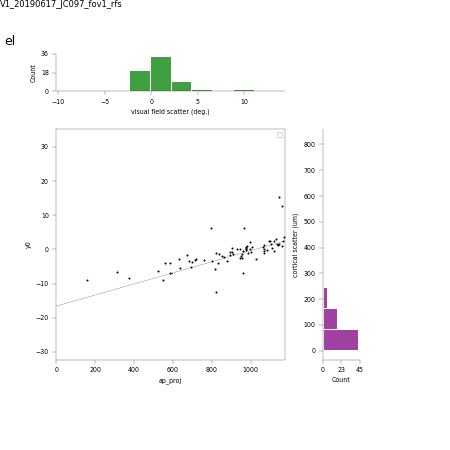

No handles with labels found to put in legend.


In [151]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    dist_lim = ml_lim if cond=='az' else ap_lim
    fig = sct.plot_scatter_and_marginals(fitrfs_, REGR_NP, roi_to_label=None, #93,
                                         cond=cond,
                                        xlim=ap_lim, ylim=None, lw=1)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    figname = 'scatter_marginals_%s_%s' % (cond, dk)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    #pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [143]:
fitrfs_[fitrfs_['cell']==78]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds


In [303]:
int(np.where(fitrfs_['cell']==78)[0])



37